In [46]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import PowerNorm

from scipy.optimize import newton
from scipy.integrate import simps

import os
from termcolor import colored
from typing import Tuple, Dict

<div class='alert alert-info' align='center'>PROFIL ARIANE IV MODIFIÉE</div>

In [47]:
# Première section du profil : section coiffe
point_nbr = 1000
radius_cover = 1.5
length_cover = 8 * radius_cover
x_cover = np.linspace(0, length_cover, point_nbr)
y_cover = radius_cover * (1 + np.sqrt(1 - np.square(np.divide(x_cover - length_cover, length_cover)))) - radius_cover

# Seconde section du profil : section droite
x_line_1 = np.linspace(length_cover, length_cover + 2 * radius_cover, point_nbr)
y_line_1 = np.full(point_nbr, radius_cover)

# Troisième section du profil : pente
length_slope_1 = length_cover + 2 * radius_cover
x_slope = np.linspace(length_slope_1, length_slope_1 + 3 * radius_cover, point_nbr)
slope_ang_1 = (0.5 * radius_cover - radius_cover) / (x_slope[-1] - x_slope[0])
y_slope = radius_cover + slope_ang_1 * (x_slope - x_slope[0])

# Quatrième section du profil : dièdre
x_start_diedre = length_slope_1 + 3 * radius_cover
length_diedre = 2 * radius_cover
slope_ang_2 = (1.5 * radius_cover - 0.5 * radius_cover) / length_diedre
x_diedre = np.linspace(x_start_diedre, x_start_diedre + length_diedre, point_nbr)
y_diedre = 0.5 * radius_cover + slope_ang_2 * (x_diedre - x_diedre[0])

# Cinquième section du profil : section droite 2
x_start_line_2 = x_start_diedre + length_diedre
x_line_2 = np.linspace(x_start_line_2, x_start_line_2 + 3 * radius_cover, point_nbr)
y_line_2 = np.full(point_nbr, 1.5 * radius_cover)

# Sixième section du profil : section booster
x_start_booster = x_start_line_2 + 3 * radius_cover
length_booster = 30
radius_booster = 2.5
x_booster = np.linspace(x_start_booster, x_start_booster + length_booster, point_nbr)
y_booster = 1.5 * radius_cover + radius_booster * (1 + np.sqrt(1 - np.square((x_booster - (x_start_booster + length_booster)) / length_booster))) - radius_booster

# Profil complet
x_profil = np.concatenate([x_cover[:point_nbr - 1], x_line_1[:point_nbr - 1], x_slope[:point_nbr - 1], x_diedre[:point_nbr - 1], x_line_2[:point_nbr - 1], x_booster])
y_profil = np.concatenate([y_cover[:point_nbr - 1], y_line_1[:point_nbr - 1], y_slope[:point_nbr - 1], y_diedre[:point_nbr - 1], y_line_2[:point_nbr - 1], y_booster])

profil_equation = {
    # Profil complet
    'x_val': x_profil,
    'y_val': y_profil,

    # caractéristiques
    'radius_cover': radius_cover,
    'length_cover': length_cover,
    'radius_booster': radius_booster,
    'length_booster': length_booster
}

profil = {

    'section_1': {
        'x_section': np.concatenate([x_cover[:point_nbr - 1], x_line_1[:point_nbr - 1]]),
        'y_section': np.concatenate([y_cover[:point_nbr - 1], y_line_1[:point_nbr - 1]]),
        'radius': radius_cover
    },
    
    'section_2': {
        'x_section': x_slope[:point_nbr - 1],
        'y_section': y_slope[:point_nbr - 1]
    },

    'section_3':{
        'x_section': x_diedre[:point_nbr - 1],
        'y_section': y_diedre[:point_nbr - 1]
    },

    'section_4':{
        'x_section': x_line_2[:point_nbr - 1],
        'y_section': y_line_2[:point_nbr - 1]
    },

    'section_5': {
        'x_section': x_booster,
        'y_section': y_booster,
        'radius': radius_booster
    }
    
}

section_shape = np.concatenate(([0], np.cumsum(np.array([len(section['x_section']) for section in profil.values()]))))

for index, section in enumerate(profil.values()):
    section["interval"] = (section_shape[index], section_shape[index + 1])

<div class='alert alert-info' align='center'>PROFIL OGIVE SIMPLE</div>

In [48]:
point_nbr = 1000
radius_cover = 2
length_cover = 30
x_cover = np.linspace(0, length_cover, point_nbr)
y_cover = radius_cover * (1 + np.sqrt(1 - np.square(np.divide(x_cover - length_cover, length_cover)))) - radius_cover

profil = {
    'section_1': {
        'x_section': x_cover,
        'y_section': y_cover,
        'radius': radius_cover
    }
}

profil_equation = {
    # Profil complet
    'x_val': x_cover,
    'y_val': y_cover,

    # caractéristiques
    'radius_cover': radius_cover,
    'length_cover': length_cover,
}

section_shape = np.concatenate(([0], np.cumsum(np.array([len(section['x_section']) for section in profil.values()]))))

for index, section in enumerate(profil.values()):
    section["interval"] = (section_shape[index], section_shape[index + 1])

profil_dictionary = {
    'profil_equation': profil_equation,
    'profil': profil,
    'section_shape': section_shape
}

In [49]:
ATM_SEA_LEVEL = {
    'Pressure': 101325,
    'Temperature': 288.15,
    'Density': 1.225,
    'Viscosity': 1.458 * 1e-6,
    'Tz': -6.5*1e-3,
    'gamma': 1.4,
    'r_air': 8.314 / (28.966*1e-3),
    'Cp': ((8.314 / (28.966*1e-3)) * 1.4) / (1.4 - 1),
    'Cv': (8.314 / (28.966*1e-3)) / (1.4 - 1),
    'gravity': 9.80665
}

def Get_ATM_at_Z(ATM_SEA_LEVEL, z) -> dict:

    Pressure_Z = ATM_SEA_LEVEL["Pressure"] * (1 + (ATM_SEA_LEVEL["Tz"]/ATM_SEA_LEVEL["Temperature"])* z) ** (- ATM_SEA_LEVEL["gravity"] / (ATM_SEA_LEVEL["Tz"] * ATM_SEA_LEVEL["r_air"]))

    Temperature_Z = ATM_SEA_LEVEL["Temperature"] + z * ATM_SEA_LEVEL["Tz"]

    Density_Z = Pressure_Z / (Temperature_Z * ATM_SEA_LEVEL["r_air"])

    Viscosity_Z = ATM_SEA_LEVEL["Viscosity"] * ( Temperature_Z ** (3/2) / (110.4 + Temperature_Z))

    ATM_Z_LEVEL = {
        'Pressure': Pressure_Z,
        'Temperature': Temperature_Z,
        'Density': Density_Z,
        'Viscosity': Viscosity_Z
    }

    return ATM_Z_LEVEL

Docs_path = os.getcwd().replace("src", "Docs")

if not os.path.exists(Docs_path):
    os.makedirs(Docs_path)
    print(f"{colored('Docs', 'green')} a été crée.")

subdirs = ["Abaques", "Output"]
path_stock = {}
for subdir in subdirs:
    subdir_path = os.path.join(Docs_path, subdir)
    if not os.path.exists(subdir_path):
        os.makedirs(subdir_path)
        print(f"Le répertoire '{colored(subdir, 'green')}' a été créé dans '{colored(Docs_path, 'yellow')}'.")
        path_stock[subdir] = subdir_path

Output_path = os.path.join(os.getcwd().replace("src", "Docs"), "Output")
Abaques_path = os.getcwd().replace("src", "Docs\Abaques")

z = 5000
FreeFlowVelocity = 3000 # m/s

ATM_Z_LEVEL = Get_ATM_at_Z(ATM_SEA_LEVEL=ATM_SEA_LEVEL, z=z)
print(ATM_Z_LEVEL)

Atmosphere = {
    'ATM_SEA_LEVEL': ATM_SEA_LEVEL,
    'ATM_Z_LEVEL': ATM_Z_LEVEL
}

directory_path = {
    'Abacus': Abaques_path,
    'Output': Output_path
}

profil_dictionary = {
    'profil_equation': profil_equation,
    'profil': profil,
    'section_shape': section_shape
}

{'Pressure': 54016.72743352968, 'Temperature': 255.64999999999998, 'Density': 0.7361409517244275, 'Viscosity': 1.6281177399287062e-05}


In [50]:
class HypersonicObliqueShock:

    def __init__(self, Atmosphere, directory_path, altitude, profil_dictionary, FreeFlowVelocity) -> None:

        # attribut
        self.Sea_Lvl = Atmosphere['ATM_SEA_LEVEL']
        self.Z_Lvl = Atmosphere["ATM_Z_LEVEL"]
        self.gamma = self.Sea_Lvl['gamma']

        self.path_Abacus = directory_path['Abacus']
        self.path_Output = directory_path['Output']
        
        self.profil_equation = profil_dictionary['profil_equation']
        self.profil = profil_dictionary['profil']
        self.section_shape = profil_dictionary['section_shape']
        self.FreeFlowVelocity = FreeFlowVelocity

        # method
            # Abacus loading and directories creation
        self.NormalShock, self.PrandtMeyer = self.LoadAbacus()
        self.Sim_path, self.ObliqueShock_path = self.simulationDir(altitude=altitude)

            # Infinite Mach Number & flow angles
        self.MachInf, self.SoundSpeed_inf = self.Get_MachNumber()
        self.Theta, self.Beta = self.Get_DeviationAndShockAngle()

            # Update profil dictionary to find the more accurate method
        self.profil = self.Get_Method(tol=0.98)
        
            # Shock layer and profil graphics
        self.x_shock_curve, self.y_shock_curve = self.Get_ShockLayer()
        self.ProfilGraphics()

            # Get Flow Variable
        self.FlowCharacteristics = self.Get_Variable()
        self.DownstreamVar_Graphics(altitude=altitude)
        
            # Stagnation variable upstream and downstream
        self.UpstreamVarStag, self.DownstreamVarStag = self.Stagnation(altitude=altitude)

            # Pressure Coefficient variation
        self.Pressure_Coeff, self.Drag_Coeff, self.Lift_Coeff = self.Coefficient(altitude=altitude)
        
            # Contour graphics
        self.Contour_Graphics(altitude=altitude)

        pass

    # Abacus loading and directories creation
    def LoadAbacus(self):

        def CheckDataDType(Abacus):

            for col in Abacus.columns.tolist():
                Abacus[col] = Abacus[col].astype(float)

            return Abacus

        try:
            NormalShock_path = os.path.join(self.path_Abacus, "NormalShockProperties.csv")
            PrandtMeyer_path = os.path.join(self.path_Abacus, "PrandtlMeyerFunctionAndMachAngle.csv")
            try:
                NormalShock = CheckDataDType(Abacus=pd.read_csv(NormalShock_path, sep=';'))
                PrandtMeyer = CheckDataDType(Abacus=pd.read_csv(PrandtMeyer_path, sep=';'))
            except Exception as error1:
                print(f"{colored('ERROR', 'red')} : {error1}")
            print(f"{colored('Abacus loading complete!', 'green')}")
        except Exception as error2:
            print(f"{colored('ERROR', 'red')} : {error2}")

        return NormalShock, PrandtMeyer

    def simulationDir(self, altitude) -> Tuple[str, str]:

        Sim_path = os.path.join(self.path_Output, f"Profil_R={self.profil_equation['radius_cover']}_Length={self.profil_equation['length_cover']}_z={altitude}")
        ObliqueShock = os.path.join(Sim_path, "ObliqueShock")

        for directory in [Sim_path, ObliqueShock]:
            if not os.path.exists(directory):
                os.makedirs(directory)
                print(f"Le répertoire {colored(directory, 'yellow')} a été créé.")
            else:
                print(f"Le répertoire {colored(directory, 'yellow')} existe déjà.")

        return Sim_path, ObliqueShock
    
    # Infinite Mach Number & flow angles and shock layer
    def Get_MachNumber(self) -> float:
        SoundSpeed = np.sqrt(self.gamma * self.Sea_Lvl['r_air'] * self.Z_Lvl['Temperature'])
        self.Z_Lvl['SoundSpeed'] = SoundSpeed
        return self.FreeFlowVelocity / SoundSpeed, SoundSpeed
    
    def Get_DeviationAndShockAngle(self):

        dy_dx = np.gradient(self.profil_equation['y_val'], self.profil_equation['x_val'])
        dy_dx[np.abs(dy_dx) < 1e-10] = 0

        Theta = np.arctan(dy_dx)
        Beta = np.zeros_like(Theta)

        def cotangent(angle):
            return np.cos(angle) / np.sin(angle)

        def betaEquation(beta, Mach, theta, gamma):
            left_side = np.tan(theta)
            right_side = 2 * cotangent(beta) * ((Mach**2 * np.sin(beta)**2 - 1) / (Mach**2 * (gamma + np.cos(2 * beta)) + 2))
            return left_side - right_side

        for index, theta_i in enumerate(Theta):
            try:
                beta_init = np.radians(30) 
                beta = newton(betaEquation, beta_init, args=(self.MachInf, theta_i, self.gamma))
                Beta[index] = beta
            except RuntimeError:
                Beta[index] = np.nan 

        return Theta, Beta

    def Get_ShockLayer(self) -> Tuple[np.ndarray, np.ndarray]:

        def delta(Diameter):
            return Diameter * 0.193 * np.exp(4.67/self.MachInf**2)
        
        x_shock_curve, y_shock_curve = [np.zeros(len(self.profil_equation['x_val'])) for _ in range(2)]
        
        x_shock_curve[x_shock_curve == 0.0] = np.nan
        y_shock_curve[y_shock_curve == 0.0] = np.nan

        self.StandOffDistance_arr = []

        for section in self.profil.values():

            interval = section['interval']
            beta_section = self.Beta[interval[0]:interval[1]]
            
            if np.any(np.isnan(beta_section)):

                first_finite_index = np.where(np.isfinite(beta_section))[0]
                
                if first_finite_index[0] != 0:
                    first_finite_value = beta_section[first_finite_index[0]]
                    beta_section[:first_finite_index[0]] = first_finite_value
                else:
                    second_finite_value = beta_section[first_finite_index[1]]
                    beta_section[:first_finite_index[1]] = second_finite_value

                if 'radius' in section:

                    StandOffDistance = delta(Diameter=2*section['radius'])
                    if section['interval'][0] == 0:
                        x_start = - StandOffDistance
                        y_start = 0
                    else:
                        x_start = np.min(section['x_section']) - StandOffDistance
                        y_start = np.min(section['y_section'])

                    self.StandOffDistance_arr.append(StandOffDistance)

                    x_end = np.max(section['x_section'])
                    y_end = np.max(section['y_section']) + StandOffDistance
                    section_length = np.sqrt((x_end - x_start) ** 2 + (y_end - y_start) ** 2)
                    point_distance = section_length / len(beta_section)

                    x_section_curve = [x_start]
                    y_section_curve = [y_start]

                    for beta in beta_section:
                        x_section_curve.append(x_section_curve[-1] + point_distance * np.cos(beta))
                        y_section_curve.append(y_section_curve[-1] + point_distance * np.sin(beta))

                    x_shock_curve[interval[0]:interval[1]] = x_section_curve[:-1]
                    y_shock_curve[interval[0]:interval[1]] = y_section_curve[:-1]

            elif section['method'] == 'Cone':

                length = np.max(section['x_section']) - np.min(section['x_section'])
                x_diedre = np.linspace(0, length, len(section['x_section']))
                y_diedre = np.tan(beta_section) * x_diedre + np.min(section['y_section'])

                x_shock_curve[interval[0]:interval[1]] = section['x_section']
                y_shock_curve[interval[0]:interval[1]] = y_diedre
            
            else:
                expansion_value = 1.3
                x_shock_curve[interval[0]:interval[1]] = section['x_section']
                y_shock_curve[interval[0]:interval[1]] = section['y_section'] * expansion_value


        return x_shock_curve, y_shock_curve
                
    def ProfilGraphics(self) -> None:

        x_profil = self.profil_equation['x_val']
        y_profil = self.profil_equation['y_val']

        radius_arr = [section['radius'] for section in self.profil.values() if 'radius' in section] 
        y_min, y_max = -5 * radius_arr[-1], 5 * radius_arr[-1]
        mu = np.arcsin(np.divide(1, self.MachInf))

        fig, axs = plt.subplots(2, 1, figsize=(15, 9), sharex='all')

        axs[0].plot(x_profil, y_profil, color='grey', label='profil')
        axs[0].plot(x_profil, -y_profil, color='grey', linestyle='-.', label='symetry')
        axs[0].fill_between(x_profil, y_profil, - y_profil, color='grey', hatch='//', alpha=0.5)

        axs[0].plot(self.x_shock_curve, self.y_shock_curve, color='red', linestyle='--', label='shock layer')
        axs[0].plot(self.x_shock_curve, -self.y_shock_curve, color='red', linestyle='--')
        
        for index in self.section_shape:
            if index == 0:
                axs[0].vlines(self.profil_equation['x_val'][index], y_min, y_max, color='#FF6500', linestyle=':', alpha=0.75)
            else:
                axs[0].vlines(self.profil_equation['x_val'][index - 1], y_min, y_max, color='#FF6500', linestyle=':', alpha=0.75)
                
        axs[0].grid('on')
        axs[0].set_ylim([-np.max(self.y_shock_curve) - 0.5, np.max(self.y_shock_curve) + 0.5])
        axs[0].set_ylabel(r"$Profil$")
        axs[0].legend(loc='upper right')
        axs[0].set_title('Studying Profil')

        axs[1].plot(x_profil, np.degrees(self.Theta), color='navy', label=r"Angle de déviation $\theta$")
        axs[1].plot(x_profil, np.degrees(self.Beta), color='red', linestyle='--', label=r"Angle de choc $\beta$")
        axs[1].plot(x_profil, np.full(len(x_profil), mu), color='purple', linestyle='-.', label=r"Angle de Mach $\mu$")
        axs[1].legend(loc='upper right')
        axs[1].grid('on')
        axs[1].set_xlabel(r"$Unit\ of\ length$")  
        axs[1].set_ylabel(r"$Angle\ [\degree]$")
        axs[1].set_ylim([np.rad2deg(np.nanmin(self.Beta[np.isfinite(self.Beta)])) - 20, np.rad2deg(np.nanmax(self.Theta[np.isfinite(self.Theta)])) + 20])

        figure_path = os.path.join(self.Sim_path, 'Geometry.png')
        plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches="tight")
        plt.show()

        x_profil = self.profil_equation['x_val']
        y_profil = self.profil_equation['y_val']

        x_profil_neg = np.flip(x_profil)
        x_profil_pos = x_profil[1:]
        x_profil_tot = np.concatenate([x_profil_neg, x_profil_pos])

        y_profil_neg = -np.flip(y_profil)
        y_profil_pos = y_profil[1:]
        y_profil_tot = np.concatenate([y_profil_neg, y_profil_pos])

        Profil = {
            "#group": np.full(len(x_profil_tot), 1),
            "#point": [f"{n:04d}" for n in range(1, len(x_profil_tot) + 1)],
            "#x_cord": x_profil_tot,
            "#y_cord": y_profil_tot,
            "#z_cord": np.zeros(len(x_profil_tot))
        }

        ProfilDataFrame = pd.DataFrame(Profil)
        ProfilDataFrame.to_csv('ArianeIV.csv', index=False, sep="\t", float_format="%.15f")

    # Update profil dictionary to find the more accurate method
    def Get_Method(self, tol) -> Dict:
        mask_neg = self.Theta < 0
        neg_arr = np.where(mask_neg == True)[0]

        if np.any(neg_arr):
            
            idx_start = np.searchsorted(self.section_shape, neg_arr[0], side='right')
            idx_end = np.searchsorted(self.section_shape, neg_arr[-1], side='right')

            if idx_start == idx_end:
                interval = (self.section_shape[idx_start - 1], self.section_shape[idx_end])

                for section in self.profil.values():
                    if section["interval"] == interval:
                        section["method"] = "Prandtl-Meyer"

        for section in self.profil.values():
            interval = section["interval"]
            theta_section = self.Theta[interval[0]:interval[1]]
            
            ref_value = np.median(theta_section)
            close_values = np.isclose(theta_section, ref_value, rtol=1e-5)
            ratio_close = np.sum(close_values) / len(theta_section)

            if np.isclose(ref_value, 0):
                section["method"] = "Rankine-Hugoniot"
            elif np.all(theta_section >= 0) and ratio_close >= tol:
                section["method"] = "Cone"
            elif np.all(theta_section >= 0):
                section["method"] = "Rankine-Hugoniot"

        return self.profil
    
    # Get Flow Variable
    def Variable_DownstreamOfShock(self, Mach) -> Dict:

        Pressure = ((2 * self.gamma * Mach**2) / (self.gamma + 1) - ((self.gamma - 1) / (self.gamma + 1))) * self.Z_Lvl["Pressure"]

        Temperature = np.divide(np.multiply((1 + 0.5 * (self.gamma - 1) * Mach**2), ((2 * self.gamma) / (self.gamma - 1)) * Mach**2 - 1), Mach**2 * np.divide((self.gamma + 1)**2, 2 * (self.gamma - 1))) * self.Z_Lvl["Temperature"]

        Density = (((self.gamma + 1) * Mach**2) / ((self.gamma - 1) * Mach**2 + 2)) * self.Z_Lvl["Density"]

        Mach_n = np.sqrt(np.divide((self.gamma - 1) * Mach**2 + 2, 2 * self.gamma * Mach**2 - (self.gamma - 1)))

        SoundSpeed_n = np.sqrt(np.divide(Temperature, ATM_Z_LEVEL["Temperature"])) * self.Z_Lvl["SoundSpeed"]

        return {
            'Pressure': Pressure,
            'Temperature': Temperature,
            'Density': Density,
            'Mach_n': Mach_n,
            'SoundSpeed_n': SoundSpeed_n,
            'Velocity_n': Mach_n * SoundSpeed_n,
        } 
    
    def PrandtlMeyerVar(self, Mach, interval, Pressure_Up, Temperature_Up) -> Dict:

        def PrandtlMeyer_Fnc(Mach):
            lambda_ = np.sqrt((self.gamma - 1) / (self.gamma + 1))
            return (1/lambda_) * np.arctan(lambda_ * np.sqrt(Mach**2 - 1)) - np.arctan(np.sqrt(Mach**2 - 1))
        
        def invPrandtlMeyer(Mach_i, nu_target):
            nu_current = PrandtlMeyer_Fnc(Mach=Mach_i)
            return nu_current - nu_target
        
        def PressureRatio(Mach_upp, Mach_down):
            return np.divide(1 + 0.5 * (self.gamma - 1)* Mach_upp**2, 1 + 0.5 * (self.gamma - 1)* Mach_down**2)**(-self.gamma/(self.gamma-1))
        
        def TemperatureRatio(Mach_upp, Mach_down):
            return (1 + 0.5*(self.gamma -1) * Mach_down**2) / (1 + 0.5 * (self.gamma - 1)) * Mach_upp**2
        
        def rho(Pressure, Temperature):
            return Pressure / (self.Sea_Lvl['r_air'] * Temperature)

        # expression de Mach au point d'impact
        Mach_n_c = np.sqrt(np.divide((self.gamma - 1) * Mach**2 + 2, 2 * self.gamma * Mach**2 - (self.gamma - 1)))
        Mach_c = Mach_n_c / (self.Beta[interval[0] - 1] - self.Theta[interval[0] - 1])

        nu_c = PrandtlMeyer_Fnc(Mach=Mach_c) # Mach ambiant after shock
        delta_arr = self.Theta[interval[0] - 1] + self.Theta[interval[0]:interval[1]]

        Pressure_val = PressureRatio(Mach_upp=Mach_c, Mach_down=Mach) * Pressure_Up
        Temperature_val = (TemperatureRatio(Mach_upp=Mach_c, Mach_down=Mach))**(-1) * Temperature_Up
        
        Beta = self.Beta[interval[0]:interval[1]]
        Theta = self.Theta[interval[0]:interval[1]]

        # vectors initialization
        vector_length = interval[1] - interval[0]
        Pressure_arr, Temperature_arr, Density_arr, Mach_n_arr, SoundSpeed_n_arr, Velocity_n_arr, nu_arr, Mach_arr = [np.zeros(vector_length) for _ in range(8)]
        for index in range(interval[1] - interval[0]):

            if index == 0:
                Mach_i = Mach_c

            nu_i = nu_c + delta_arr[index]
            Mach_i = newton(invPrandtlMeyer, Mach_i, args=(nu_i, ))

            nu_arr[index] = nu_i
            Mach_arr[index] = Mach_i
            Mach_n_arr[index] = Mach_i * np.abs(np.sin(Beta[index] - Theta[index]))
            Pressure_arr[index] = PressureRatio(Mach_upp=Mach_c, Mach_down=Mach_n_arr[index]) * Pressure_val
            Temperature_arr[index] = TemperatureRatio(Mach_upp=Mach_n_arr[index], Mach_down=Mach_c) * Temperature_val
            Density_arr[index] = rho(Pressure=Pressure_arr[index], Temperature=Temperature_arr[index])
            SoundSpeed_n_arr[index] = np.sqrt(self.gamma * self.Sea_Lvl['r_air'] * Temperature_arr[index])
            Velocity_n_arr[index] = Mach_n_arr[index] * SoundSpeed_n_arr[index]
            
        return {
            'Pressure': Pressure_arr,
            'Temperature': Temperature_arr,
            'Density': Density_arr,
            'Mach_n': Mach_n_arr,
            'Mach_amb': Mach_arr,
            'SoundSpeed_n': SoundSpeed_n_arr,
            'Velocity_n': Velocity_n_arr,
        }

    def Get_Variable(self) -> Dict:

        # vectors initialization
        Pressure_arr, Temperature_arr, Density_arr, Mach_n_arr, Mach_amb_arr, SoundSpeed_n_arr, Velocity_n_arr = [np.zeros(len(self.profil_equation['x_val'])) for _ in range(7)]

        for section in self.profil.values():

            value = section['interval']

            if section['method'] == 'Rankine-Hugoniot' or section['method'] == 'Cone':

                dictionary = self.Variable_DownstreamOfShock(Mach=self.MachInf*np.sin(self.Beta[value[0]:value[1]]))

                Pressure_arr[value[0]:value[1]] = dictionary['Pressure']
                Temperature_arr[value[0]:value[1]] = dictionary['Temperature']
                Density_arr[value[0]:value[1]] = dictionary['Density']
                Mach_n_arr[value[0]:value[1]] = dictionary['Mach_n']
                SoundSpeed_n_arr[value[0]:value[1]] = dictionary['SoundSpeed_n']
                Velocity_n_arr[value[0]:value[1]] = dictionary['Velocity_n']

                Mach_amb = Mach_n_arr[value[0]:value[1]] / np.sin(self.Beta[value[0]:value[1]] - self.Theta[value[0]:value[1]])
                # Mach_amb[Mach_amb < 0] = np.min(Mach_amb[Mach_amb > 0])
                Mach_amb_arr[value[0]:value[1]] = Mach_amb

            elif section['method'] == 'Prandtl-Meyer':

                dictionary = self.PrandtlMeyerVar(Mach=self.MachInf*np.sin(self.Beta[value[0] - 1]), interval=value, Pressure_Up=self.Z_Lvl['Pressure'], Temperature_Up=self.Z_Lvl['Temperature'])
                Pressure_arr[value[0]:value[1]] = dictionary["Pressure"]
                Temperature_arr[value[0]:value[1]] = dictionary["Temperature"]
                Density_arr[value[0]:value[1]] = dictionary["Density"]
                Mach_n_arr[value[0]:value[1]] = dictionary["Mach_n"]
                SoundSpeed_n_arr[value[0]:value[1]] = dictionary['SoundSpeed_n']
                Velocity_n_arr[value[0]:value[1]] = dictionary['Velocity_n']

                Mach_amb_arr[value[0]:value[1]] = dictionary["Mach_amb"]

        FlowCharacteristics = {
            'Pressure': Pressure_arr,
            'Temperature': Temperature_arr,
            'Density': Density_arr,
            'Mach_n': Mach_n_arr,
            'Mach_amb': Mach_amb_arr,
            'SoundSpeed_n': SoundSpeed_n_arr,
            'Velocity_n': Velocity_n_arr
        }

        return FlowCharacteristics
    
    def DownstreamVar_Graphics(self, altitude) -> None:
        Mach_amb = self.FlowCharacteristics['Mach_amb']
        Mach_amb[np.abs(Mach_amb) > self.MachInf] = 0
        Mach_amb[Mach_amb < 0] = 0
        x_val = self.profil_equation['x_val']

        fig, axs = plt.subplots(3, 2, figsize=(15, 9), sharex='all')
        fig.suptitle(f'Evolution of flow characteristics after impact\nat Mach {self.MachInf:.10f}, z = {altitude} m', fontsize=16)

        ylabels = [r'$Pressure\ [Pa]$', r'$Temperature\ [K]$', r'$Density\ [kg.m^{-3}]$', r'$Mach$', r'$Sound\ Speed\ [m.s^{-1}]$', r'$Velocity\ [m.s^{-1}]$']
        label = ['Pressure', 'Temperature', 'Density', r'$M_n$', r'$a_n$', r'$V_n$']
        dic_val = ['Pressure', 'Temperature', 'Density', 'Mach_n', 'SoundSpeed_n', 'Velocity_n']

        for ax, ylabel, Var, label in zip(axs.flat, ylabels, dic_val, label):
            ax.plot(x_val, self.FlowCharacteristics[Var], color='navy', label=label)
            if label == "Pressure":
                ax.set_yscale('log')
            elif Var == "Mach_n":
                ax.plot(x_val, Mach_amb, color="#7AB2D3", linestyle='-.', label='Mach ambiant')
                ax.plot(x_val, np.full(len(x_val), self.MachInf), color="#3B1E54", linestyle=':', linewidth=2, label=r'$Mach_{\infty}$')
            elif Var == "Velocity_n":
                V_amb = self.FlowCharacteristics[Var] * Mach_amb
                ax.plot(x_val, V_amb, color="#7AB2D3", linestyle='-.', label='Velocity norm')
                ax.plot(x_val, np.full(len(x_val), self.FreeFlowVelocity), color="#3B1E54", linestyle=':', linewidth=2, label='Free Flow Velocity')
            elif Var == "SoundSpeed_n":
                # ax.plot(x_val, self.FlowCharacteristics[Var] * Mach_amb, color="#7AB2D3", linestyle='-.', label='Sound Speed norm')
                ax.plot(x_val, np.full(len(x_val), self.SoundSpeed_inf), color="#3B1E54", linestyle=':', linewidth=2, label='Free Flow Sound Speed')

            ax.set_ylabel(ylabel)
            ax.grid('on')
            ax.legend(loc='upper right')
        
        figure_path = os.path.join(self.Sim_path, 'DownstreamVariables.png')
        plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches="tight")

        plt.show()
    
    # Stagnation variable upstream and downstream        
    def Stagnation(self, altitude) -> Tuple[Dict, Dict]:

        x_val = self.profil_equation['x_val']

        def Var(Mach, dictionary):
            P_stag = (1 + 0.5 * (self.gamma - 1) * Mach**2)**(self.gamma/(self.gamma - 1)) * dictionary['Pressure']
            T_stag = (1 + 0.5 * (self.gamma - 1) * Mach**2) * dictionary['Temperature']
            rho_stag = ((1 + 0.5 * (self.gamma - 1) * Mach**2) ** (1/(self.gamma - 1))) * dictionary['Density']

            return {
                'P_stag': P_stag,
                'T_stag': T_stag,
                'rho_stag': rho_stag
            }
        
        UpstreamVarStag = Var(Mach=np.full(len(x_val), self.MachInf), dictionary=self.Z_Lvl)
        DownstreamVarStag = Var(Mach=self.FlowCharacteristics["Mach_n"], dictionary=self.FlowCharacteristics)

        var_name = ["P_stag", "T_stag", "rho_stag"]
        ylabel_ = [r'Pressure $[Pa]$', r'Temperature $[K]$', r'Density $[kg.m^{-3}]$']
        
        fig, axs = plt.subplots(1, 3, figsize=(16, 6))
        fig.suptitle(f"Evolution of Stagnation Variable Upstream and Downstream\nat Mach {self.MachInf:.10f}, z = {altitude} m", fontsize=16)

        for ax, label, ylabel in zip(axs.flat, var_name, ylabel_):
            ax.plot(x_val, UpstreamVarStag[label], color='navy', linestyle='-.', label="Upstream")
            ax.plot(x_val, DownstreamVarStag[label], color='red', linestyle='--', label="Downstream")
            ax.grid('on')
            ax.legend(loc="upper right")
            ax.set_ylabel(ylabel)
            ax.set_xlabel(r'$Unit\ of\ length$')

            if label in ["P_stag", "rho_stag"]:
                ax.set_yscale('log')

        figure_path = os.path.join(self.Sim_path, 'StagnationVariables.png')
        plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches="tight")
        plt.show()

        return UpstreamVarStag, DownstreamVarStag
    
    # Pressure, Drag and Lift Coeff
    def Coefficient(self, altitude):

        def Aero_Forces(Coeff, S_ref):
            # Calcule la force aérodynamique en fonction du coefficient et de la surface de référence
            return 0.5 * self.Z_Lvl['Density'] * self.FreeFlowVelocity**2 * S_ref * Coeff

        # Initialisation des tableaux pour les coefficients
        Cp_arr, dsx_arr, dsy_arr, dCx_arr, dCy_arr = [np.zeros(len(self.Theta)) for _ in range(5)]

        # Calcul de la surface de référence globale en additionnant les surfaces de chaque section
        S_ref = 0  # On initialise S_ref à 0 pour l'incrémenter
        for section in self.profil.values():
            interval = section['interval']

            # Calcul de la surface de référence pour chaque section
            S_ref_section = np.abs(simps(section['y_section'], x=section['x_section']))
            S_ref += S_ref_section  # Ajoute la surface de référence de chaque section

            if 'radius' in section:
                # Calcul du coefficient de pression pour une section arrondie
                Kp_star = (2/self.gamma) * ((self.gamma + 1)/2)**(self.gamma/(self.gamma - 1)) * ((self.gamma + 1)/(2 * self.gamma))**(1/(self.gamma - 1))
                Cp_blunt = Kp_star * np.sin(self.Theta[interval[0]:interval[1]]) ** 2
                Cp_arr[interval[0]:interval[1]] = Cp_blunt

                # Calcul des coefficients de traînée et de portance locaux
                ds = np.sqrt(np.diff(section['x_section'])**2 + np.diff(section['y_section'])**2)
                ds = np.append(ds, ds[-1])

                dsx_arr[interval[0]:interval[1]] = ds * np.cos(self.Theta[interval[0]:interval[1]])
                dsy_arr[interval[0]:interval[1]] = ds * np.sin(self.Theta[interval[0]:interval[1]])

                dCx_arr[interval[0]:interval[1]] = - Cp_blunt * dsx_arr[interval[0]:interval[1]] / S_ref_section
                dCy_arr[interval[0]:interval[1]] = np.abs(- Cp_blunt * dsy_arr[interval[0]:interval[1]] / S_ref_section)

            elif section['method'] == "Cone":
                # Calcul du coefficient de pression pour une section conique
                Kp_star = 2 * (self.gamma + 1) * (self.gamma + 7) / (self.gamma + 3)**2
                Cp_diedre = Kp_star * np.sin(self.Theta[interval[0]:interval[1]]) ** 2
                Cp_arr[interval[0]:interval[1]] = Cp_diedre

                # Calcul des coefficients de traînée et de portance locaux
                ds = np.sqrt(np.diff(section['x_section'])**2 + np.diff(section['y_section'])**2)
                ds = np.append(ds, ds[-1])

                dsx_arr[interval[0]:interval[1]] = ds * np.cos(self.Theta[interval[0]:interval[1]])
                dsy_arr[interval[0]:interval[1]] = ds * np.sin(self.Theta[interval[0]:interval[1]])

                dCx_arr[interval[0]:interval[1]] = - Cp_diedre * dsx_arr[interval[0]:interval[1]] / S_ref_section
                dCy_arr[interval[0]:interval[1]] = np.abs(- Cp_diedre * dsy_arr[interval[0]:interval[1]] / S_ref_section)

            elif section['method'] == "Prandtl-Meyer":
                # Calcul du coefficient de pression pour une section Prandtl-Meyer
                Cp_ = 2 / (2*self.MachInf**2) * (self.FlowCharacteristics['Pressure'][interval[0]:interval[1]]/self.Z_Lvl['Pressure'] - 1)
                Cp_arr[interval[0]:interval[1]] = Cp_

                # Calcul des coefficients de traînée et de portance locaux
                ds = np.sqrt(np.diff(section['x_section'])**2 + np.diff(section['y_section'])**2)
                ds = np.append(ds, ds[-1])

                dsx_arr[interval[0]:interval[1]] = ds * np.cos(self.Theta[interval[0]:interval[1]])
                dsy_arr[interval[0]:interval[1]] = ds * np.sin(self.Theta[interval[0]:interval[1]])

                dCx_arr[interval[0]:interval[1]] = - Cp_ * dsx_arr[interval[0]:interval[1]] / S_ref_section
                dCy_arr[interval[0]:interval[1]] = np.abs(- Cp_ * dsy_arr[interval[0]:interval[1]] / S_ref_section)

            else:
                # Calcul du coefficient de pression pour une section standard
                q_inf = 0.5 * self.Z_Lvl['Density'] * self.FreeFlowVelocity**2
                Cp_ = (self.FlowCharacteristics['Pressure'][interval[0]:interval[1]] - self.Z_Lvl['Pressure']) / q_inf
                Cp_arr[interval[0]:interval[1]] = Cp_

                # Calcul des coefficients de traînée et de portance locaux
                ds = np.sqrt(np.diff(section['x_section'])**2 + np.diff(section['y_section'])**2)
                ds = np.append(ds, ds[-1])

                dsx_arr[interval[0]:interval[1]] = ds * np.cos(self.Theta[interval[0]:interval[1]])
                dsy_arr[interval[0]:interval[1]] = ds * np.sin(self.Theta[interval[0]:interval[1]])

                dCx_arr[interval[0]:interval[1]] = - Cp_ * dsx_arr[interval[0]:interval[1]] / S_ref_section
                dCy_arr[interval[0]:interval[1]] = np.abs(- Cp_ * dsy_arr[interval[0]:interval[1]] / S_ref_section)

        # Calcul des coefficients globaux de traînée et de portance
        self.Cx = np.sum(dCx_arr)
        self.Cy = np.sum(dCy_arr)
        print(f"Coefficient de traînée le long du profil : {colored(self.Cx, 'red')}")
        print(f"Coefficient de portance le long du profil : {colored(self.Cy, 'red')}\n")

        # Calcul des forces de traînée et de portance
        self.F_x = 2 * Aero_Forces(Coeff=self.Cx, S_ref=S_ref)
        self.F_y = Aero_Forces(Coeff=self.Cy, S_ref=S_ref)
        print(f"Force de traînée le long du profil : {colored(self.F_x, 'red')} N")
        print(f"Force de portance le long du profil : {colored(self.F_y, 'red')} N")

        # Graphique de la variation du coefficient de pression et des coefficients de traînée et portance locaux
        fig, axs = plt.subplots(1, 3, figsize=(19, 6))
        fig.suptitle(f"Pressure coefficient variation\nat Mach {self.MachInf} z = {altitude} m ")

        y_fnc_dict = {
            'Cp_arr': Cp_arr,
            'dCx_arr': dCx_arr,
            'dCy_arr': dCy_arr
        }
        ylabel_ = ['Pressure Coefficient', 'Drag Coeff by unit of length', 'Lift Coeff by unit of length']
        label_ = ["Pressure Coefficient", "Drag Coeff", "Lift Coeff"]

        for ax, y_fnc, ylabel, label in zip(axs.flat, y_fnc_dict.values(), ylabel_, label_):
            ax.plot(self.profil_equation['x_val'], y_fnc, color='navy', label=label)
            ax.legend()
            ax.grid('on')
            ax.set_xlabel('Unit of length')
            ax.set_ylabel(ylabel)

        # Sauvegarde de la figure
        figure_path = os.path.join(self.Sim_path, 'Coefficient.png')
        plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches="tight")
        plt.show()

        return Cp_arr, dCx_arr, dCy_arr

    # Contour graphics
    def Contour_Graphics(self, altitude):
        x_profil = self.profil_equation['x_val']
        y_profil = self.profil_equation['y_val']
        y_shock_curve = self.y_shock_curve
        x_shock_curve = self.x_shock_curve

        x_extension = np.linspace(-10, 0, 1000)
        y_extension = np.zeros_like(x_extension)

        x_contour = np.concatenate([x_extension, x_profil])
        y_contour = np.concatenate([y_extension, y_profil])

        X_mesh = x_contour
        Y_mesh = np.linspace(-np.max(y_shock_curve) - 0.5, np.max(y_shock_curve) + 0.5, len(y_contour))
        X_grid, Y_grid = np.meshgrid(X_mesh, Y_mesh)

        ## split shock curve
        if np.any(self.x_shock_curve < 0):
            index_before_0 = np.where(self.x_shock_curve < 0)[0]
            x_shock_curve_neg = x_shock_curve[index_before_0[0]:index_before_0[-1] + 1]
            x_shock_curve_pos = x_shock_curve[index_before_0[-1] + 1:]

            index_in_x_extension = np.array([np.abs(x_extension - x_vals).argmin() for x_vals in x_shock_curve_neg])
            mapping_before_0 = {ext_index: shock_index for ext_index, shock_index in zip(index_in_x_extension, index_before_0)}

        # Matrix definition
        Pressure_Matrix = np.full((len(Y_mesh), len(X_mesh)), self.Z_Lvl['Pressure'])
        Temperature_Matrix = np.full((len(Y_mesh), len(X_mesh)), self.Z_Lvl['Temperature'])
        Density_Matrix = np.full((len(Y_mesh), len(X_mesh)), self.Z_Lvl['Density'])

        for index in range(len(y_profil)):

            if x_profil[index] >= np.min(X_mesh) and x_profil[index] <= np.max(X_mesh):

                upper_bound = y_profil[index]
                lower_bound = - y_profil[index]

                x_index = np.argmin(np.abs(X_mesh - x_profil[index]))
                x_index_shock = np.argmin(np.abs(x_shock_curve - x_profil[index]))

                inside_mask = (Y_grid[:, x_index] >= lower_bound) & (Y_grid[:, x_index] <= upper_bound)
                between_profil_shock_mask_upper = (Y_grid[:, x_index] <= y_shock_curve[x_index_shock]) & (Y_grid[:, x_index] > y_profil[index])
                between_profil_shock_mask_lower = (Y_grid[:, x_index] >= -y_shock_curve[x_index_shock]) & (Y_grid[:, x_index] < -y_profil[index])

                # Pressure
                Pressure_Matrix[inside_mask, x_index] = np.nan
                Pressure_Matrix[between_profil_shock_mask_upper, x_index] = self.FlowCharacteristics["Pressure"][index]
                Pressure_Matrix[between_profil_shock_mask_lower, x_index] = self.FlowCharacteristics["Pressure"][index]

                # Temperature
                Temperature_Matrix[inside_mask, x_index] = np.nan
                Temperature_Matrix[between_profil_shock_mask_upper, x_index] = self.FlowCharacteristics["Temperature"][index]
                Temperature_Matrix[between_profil_shock_mask_lower, x_index] = self.FlowCharacteristics["Temperature"][index]

                # Density
                Density_Matrix[inside_mask, x_index] = np.nan
                Density_Matrix[between_profil_shock_mask_upper, x_index] = self.FlowCharacteristics["Density"][index]
                Density_Matrix[between_profil_shock_mask_lower, x_index] = self.FlowCharacteristics["Density"][index]

        if len(self.profil) > 1:
            
            for index_section, section in enumerate(self.profil.values()):

                if 'radius' in section and index_section != 0:

                    min_value = section['interval'][0]
                    x_curve_index = np.where((x_shock_curve <= x_profil[min_value]) & (x_shock_curve >= x_profil[min_value] - self.StandOffDistance_arr[-1]) & (x_profil >= x_profil[min_value]))[0]
                    x_profil_index = np.where((x_profil <= x_profil[min_value]) & (x_profil >= x_profil[min_value] - self.StandOffDistance_arr[-1]))[0]
                    interpolated_y_curve = np.linspace(y_shock_curve[x_curve_index][0], y_shock_curve[x_curve_index][-1], len(x_profil_index))

                    for index in range(len(x_profil_index)):

                        upper_bound = interpolated_y_curve[index]
                        lower_bound = y_profil[x_profil_index[index]]

                        shock_curve_upper_mask = (Y_grid[:, x_profil_index[index]] <= upper_bound) & (Y_grid[:, x_profil_index[index]] >= lower_bound)
                        shock_curve_lower_mask = (Y_grid[:, x_profil_index[index]] >= -upper_bound) & (Y_grid[:, x_profil_index[index]] <= -lower_bound)

                        # Pressure
                        Pressure_Matrix[shock_curve_upper_mask, x_profil_index[index] + len(x_extension)] = np.max(self.FlowCharacteristics["Pressure"])
                        Pressure_Matrix[shock_curve_lower_mask, x_profil_index[index] + len(x_extension)] = np.max(self.FlowCharacteristics["Pressure"])

                        # Temperature
                        Temperature_Matrix[shock_curve_upper_mask, x_profil_index[index] + len(x_extension)] = np.max(self.FlowCharacteristics["Temperature"])
                        Temperature_Matrix[shock_curve_lower_mask, x_profil_index[index] + len(x_extension)] = np.max(self.FlowCharacteristics["Temperature"])

                        # Density
                        Density_Matrix[shock_curve_upper_mask, x_profil_index[index] + len(x_extension)] = np.max(self.FlowCharacteristics["Density"])
                        Density_Matrix[shock_curve_lower_mask, x_profil_index[index] + len(x_extension)] = np.max(self.FlowCharacteristics["Density"])

        if np.any(self.x_shock_curve < 0):
            for index in range(len(y_extension)):

                if index in index_in_x_extension:
                    corresponding_index = mapping_before_0[index]
                    upper_bound = y_shock_curve[corresponding_index]
                    lower_bound = - y_shock_curve[corresponding_index]
                    
                    between_shock_mask = (Y_grid[:, index] >= lower_bound) & (Y_grid[:, index] <= upper_bound)

                    # Pressure
                    Pressure_Matrix[between_shock_mask, index] = np.max(self.FlowCharacteristics["Pressure"])

                    # Temperature
                    Temperature_Matrix[between_shock_mask, index] = np.max(self.FlowCharacteristics["Temperature"])

                    # Density
                    Density_Matrix[between_shock_mask, index] = np.max(self.FlowCharacteristics["Density"])


        fig, axs = plt.subplots(3, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)
        fig.suptitle(f"State Variable contours at z = {altitude} m ", fontsize=18)

        contour_label = [r"$Pressure\ variation\ [Pa]$", r"$Temperature\ variation\ [K]$", r"$Density\ variation\ [kg.m^{-3}]$"]
        matrix_variable = [Pressure_Matrix, Temperature_Matrix, Density_Matrix]
        key_var = ["Pressure", "Temperature", "Density"]

        for ax, matrix_var, c_label, key in zip(axs.flat, matrix_variable, contour_label, key_var):

            norm = PowerNorm(gamma=0.4, vmin=np.nanmin(self.FlowCharacteristics[key]), vmax=np.nanmax(matrix_var))
            c_variable = ax.contourf(X_grid, Y_grid, matrix_var, levels=125, cmap='jet', norm=norm)
            fig.colorbar(c_variable, ax=ax, label=c_label)

            ax.plot(x_profil, y_profil, color='black', label='Profil')
            ax.plot(x_profil, -y_profil, color='black')
            ax.plot(self.x_shock_curve, self.y_shock_curve, color='#F5F5F7', linestyle='--', linewidth=0.5, label='shock layer')
            ax.plot(self.x_shock_curve, -self.y_shock_curve, color='#F5F5F7', linestyle='--', linewidth=0.5)
            ax.fill_between(x_profil, -y_profil, y_profil, color='black', alpha=0.5, hatch='//', label='profil')
            ax.legend(loc='upper left')

        figure_path = os.path.join(self.Sim_path, 'ContourGraphics.png')
        plt.savefig(figure_path, dpi=300, transparent=True, bbox_inches="tight")
        plt.show()

<div class="alert alert-info" align="center"><b>INITIALISATION DES CLASSES</b></div>

Abacus loading complete!
Le répertoire c:\Users\plamb\Desktop\Elisa Aerospace\Elisa 5\Aerodynamique_Hypersonique\Docs\Output\Profil_R=2_Length=30_z=5000 existe déjà.
Le répertoire c:\Users\plamb\Desktop\Elisa Aerospace\Elisa 5\Aerodynamique_Hypersonique\Docs\Output\Profil_R=2_Length=30_z=5000\ObliqueShock existe déjà.


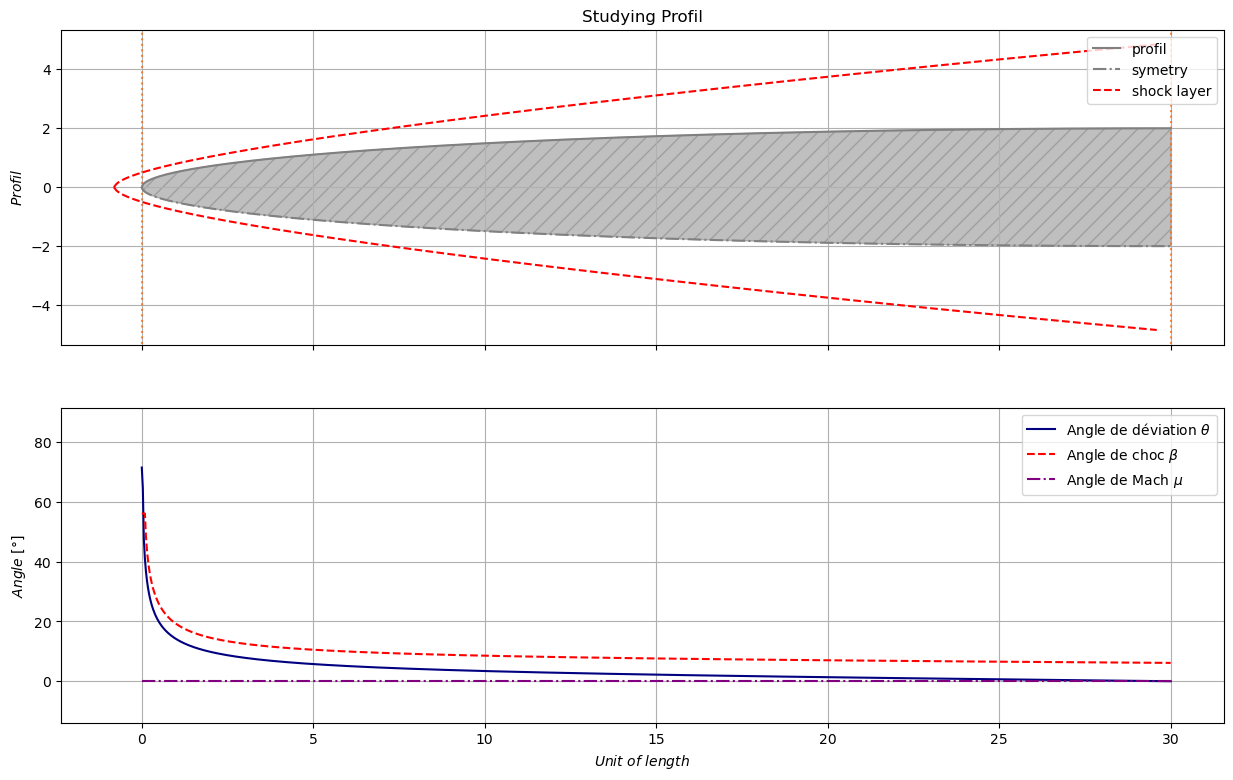

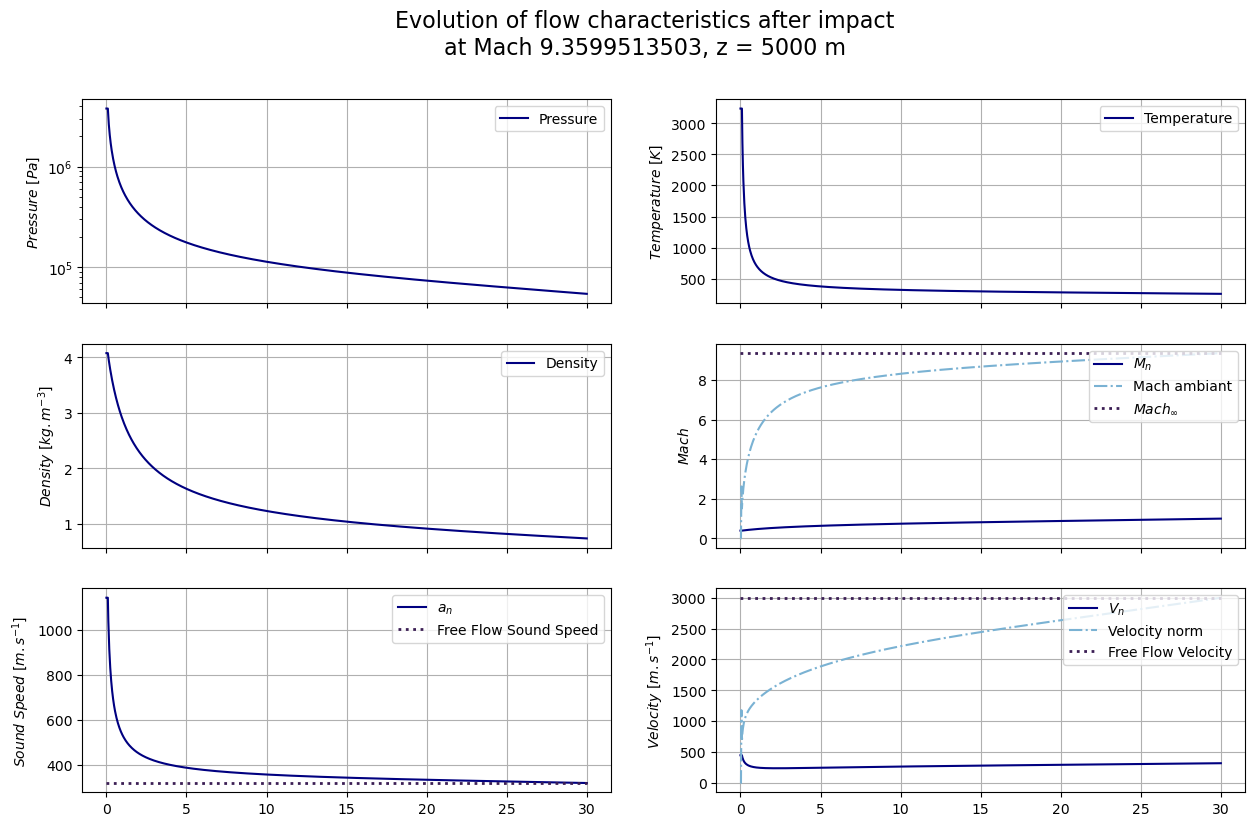

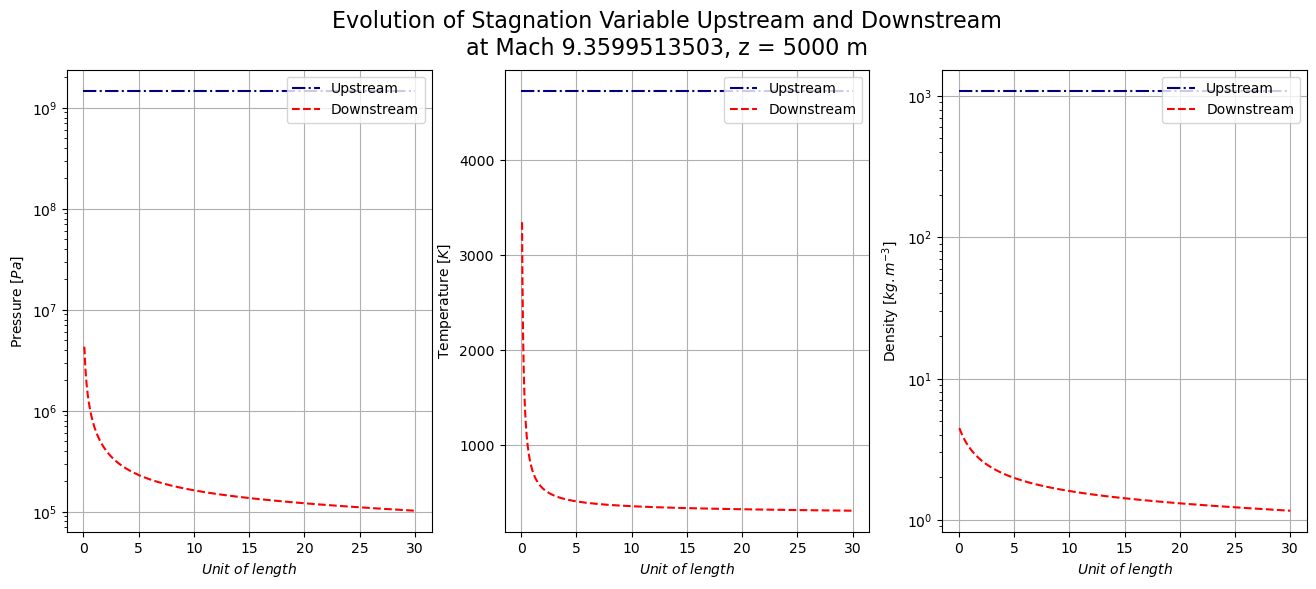

Coefficient de traînée le long du profil : -0.012890773850241172
Coefficient de portance le long du profil : 0.008433421802739474

Force de traînée le long du profil : -4024579.621561404 N
Force de portance le long du profil : 1316483.320615462 N


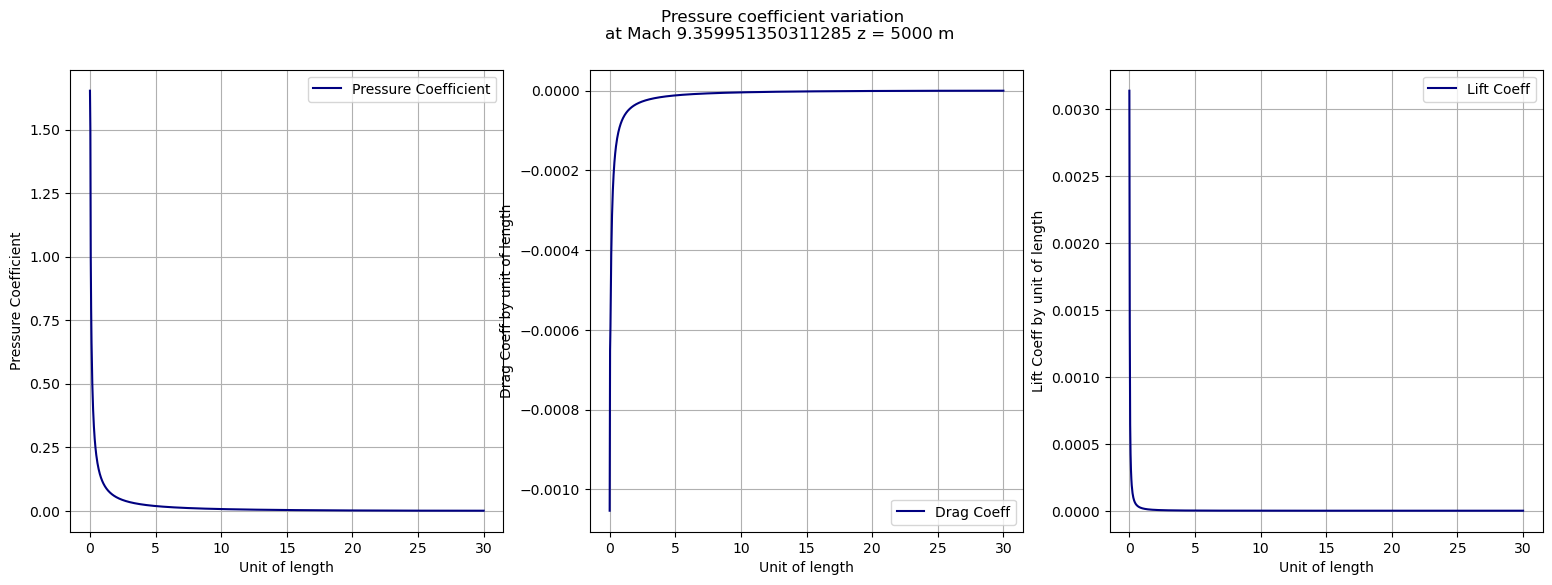

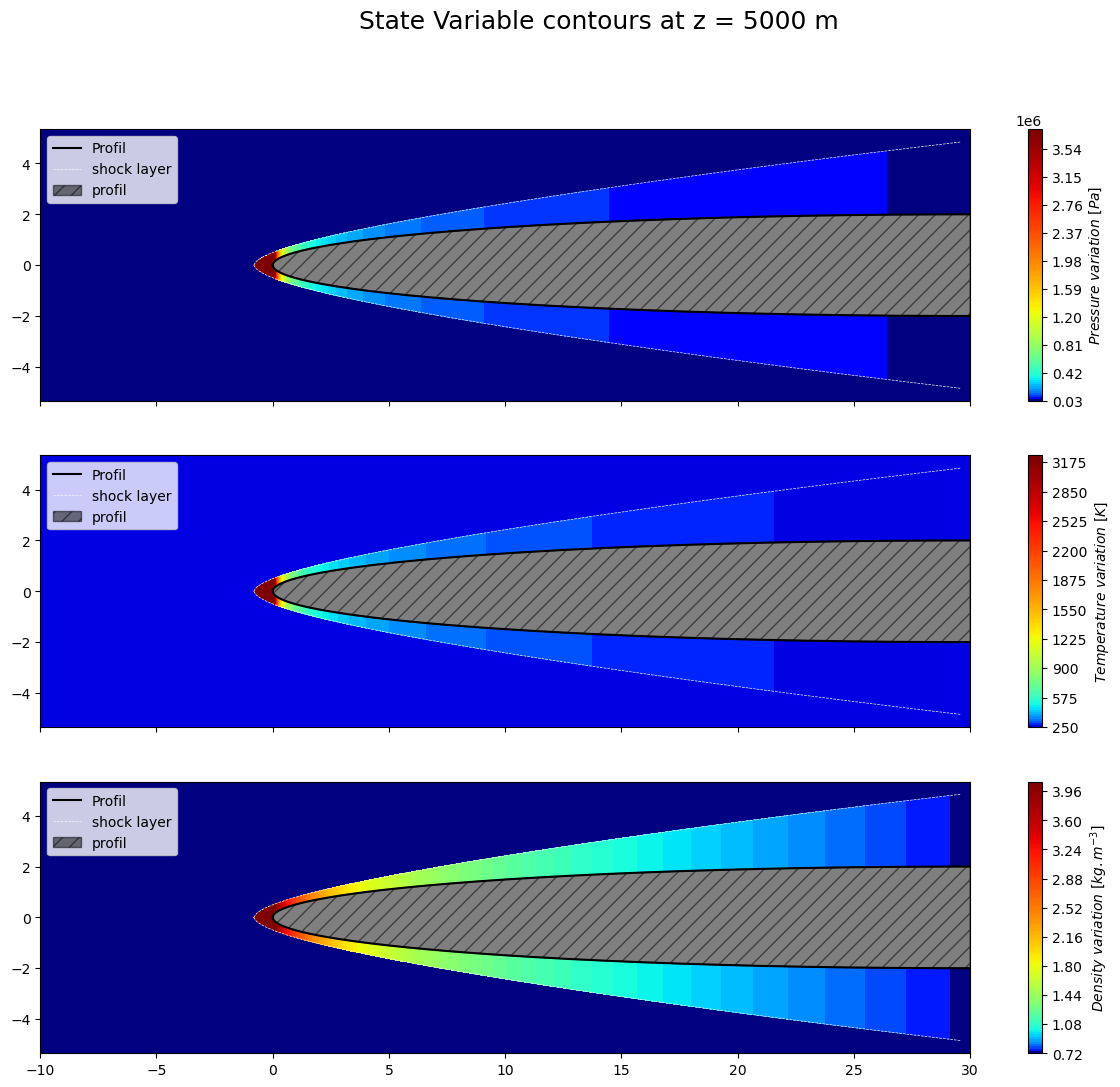

In [51]:
Hyper_OS = HypersonicObliqueShock(Atmosphere, directory_path, z, profil_dictionary, FreeFlowVelocity)